# Задача 4. Ансамбли

- Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

# устанавливаем точность чисел с плавающей точкой
%precision % .4f

import warnings

warnings.filterwarnings('ignore')  # отключаем предупреждения
dataset_path = pathlib.Path().resolve().parent / "datasets" / "exams" / "exams.csv"

# Датасет
Будет использован **сгенерированный** [Датасет](http://roycekimmons.com/tools/generated_data/exams), который описывает результаты экзаменов для разных групп людей.

Будет решаться задача регрессии: определение суммы всех баллов.
gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score

Нецелевые атрибуты:
  - **gender** - пол человека(male/female)
  - **race/ethnicity** - возможная раса или этническая принадлежность(group A, group B, group C, group D, group E)
  - **parental level of education** - уровень образования родителей(high school, some high school, some college, associate's degree, bachelor's degree, master's degree)
  - **lunch** - какой обед получает человек(free/reduced, standard)
  - **test preparation course** - закончил ли студент курсы по подготовке(completed, none)
  - **math score** - оценка за тест по математике
  - **reading score** - оценка за тест по чтению
  - **writing score** - оценка за тест по письму

In [2]:
df = pd.read_csv(dataset_path)

# 1.EDA

In [3]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,free/reduced,none,47,50,51
1,male,group C,high school,free/reduced,completed,61,62,65
2,female,group B,high school,standard,none,61,77,77
3,female,group E,high school,free/reduced,none,64,72,70
4,male,group C,high school,standard,none,62,69,62


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       10000 non-null  object
 1   race/ethnicity               10000 non-null  object
 2   parental level of education  10000 non-null  object
 3   lunch                        10000 non-null  object
 4   test preparation course      10000 non-null  object
 5   math score                   10000 non-null  int64 
 6   reading score                10000 non-null  int64 
 7   writing score                10000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 625.1+ KB


Нулевых значений нет
Заменим данные для типов типа object на int

In [5]:
df['gender'].replace(['female', 'male'], [0, 1], inplace=True)

df['race/ethnicity'].replace(
    ['group A', 'group B', 'group C', 'group D', 'group E'],
    [1, 2, 3, 4, 5],
    inplace=True
)

df['parental level of education'].replace(
    ['high school', 'some high school', 'some college', 'associate\'s degree', 'bachelor\'s degree',
     'master\'s degree'],
    [1, 2, 3, 4, 5, 6],
    inplace=True
)

df['lunch'].replace(
    ['free/reduced', 'standard'],
    [1, 2],
    inplace=True
)

df['test preparation course'].replace(
    ['none', 'completed'],
    [1, 2],
    inplace=True
)

for i in df:
    df['total score'] = df['math score'] + df['reading score'] + df['writing score']

Добавил новый **total score**, который является суммой баллов.

In [6]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,0,4,3,1,1,47,50,51,148
1,1,3,1,1,2,61,62,65,188
2,0,2,1,2,1,61,77,77,215
3,0,5,1,1,1,64,72,70,206
4,1,3,1,2,1,62,69,62,193


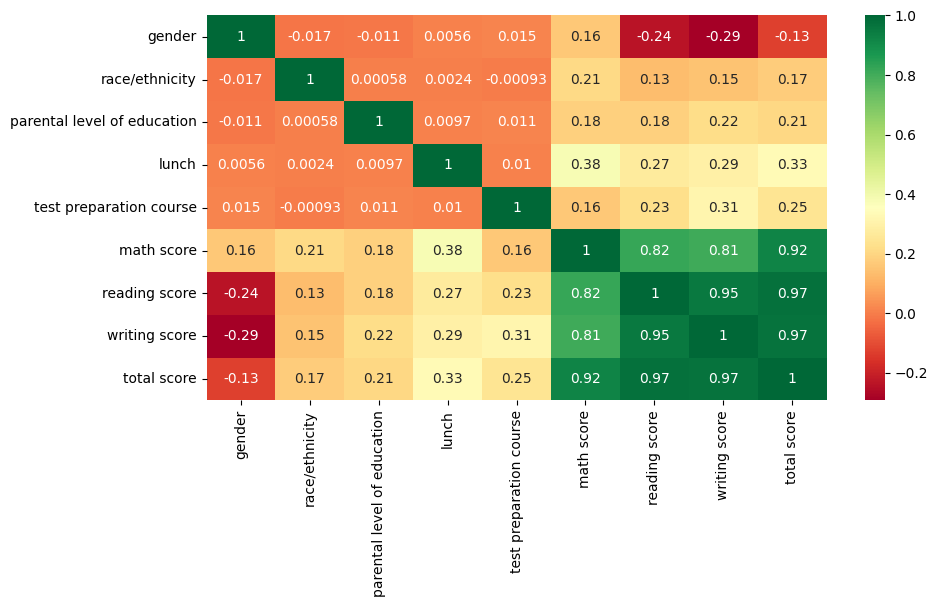

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Мы видим высокую корреляцию между total score и всеми экзаменами, что не удивительно. Поэтому надо убрать параметры всех трёх экзаменов.

In [8]:
df.drop(columns=['math score', 'reading score', 'writing score'], inplace=True)

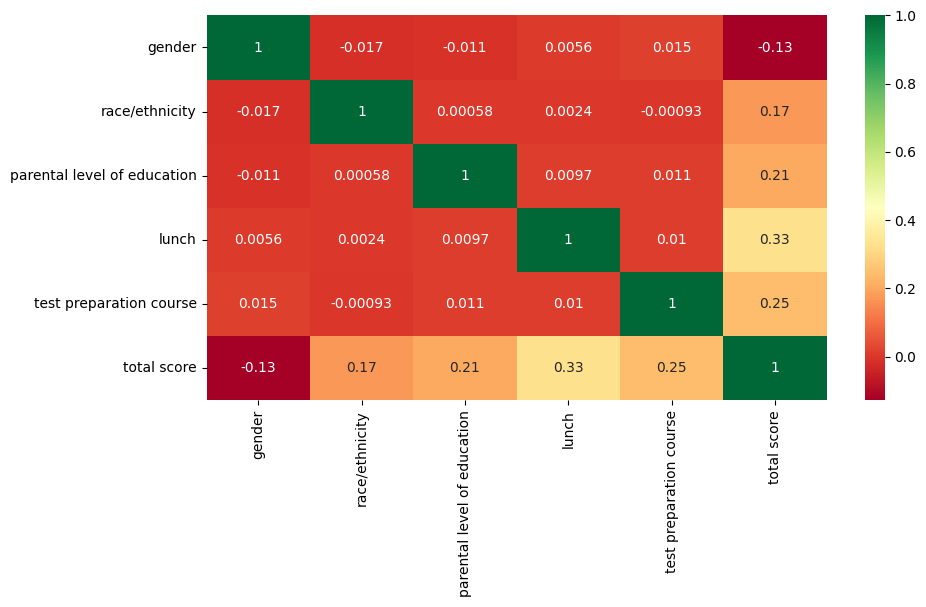

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [10]:
df_x = df.drop(columns=["total score"])
df_y = df["total score"]

# Собственные Bagging/AdaBoost

In [11]:
import sklearn
from sklearn.ensemble import BaseEnsemble

np.random.seed(42)

class SelfWritedBagging(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        preds = [estimator.predict(x) for estimator in self.estimators_]
        return np.mean(preds, axis=0)

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor()

        self.estimators_ = list()
        for _ in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            x_r, y_r = sklearn.utils.resample(x, y)
            est.fit(x_r, y_r)
            self.estimators_.append(est)


class SelfWritedAdaBoost(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        return np.around(sum((self.alphas[i] * self.estimators_[i].predict(x) for i in range(self.n_estimators))))

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor(max_depth=3)

        self.estimators_ = list()
        self.alphas = [0 for _ in range(self.n_estimators)]
        weight = [1.0 for _ in y]

        for i in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            est.fit(x, y, weight)
            error = 1 - est.score(x, y, weight)
            self.alphas[i] = np.log((1 - error) / error)
            weight = weight * np.exp(self.alphas[i] * (y != est.predict(x)))
            weight = weight / sum(weight) * len(y)
            self.estimators_.append(est)

        self.alphas /= sum(self.alphas)

## Optuna

In [12]:
import optuna

def optuna_train(estimator, params):
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(seed=42), direction="maximize")
    x = df_x
    y = df_y

    model = optuna.integration.OptunaSearchCV(
        estimator,
        params,
        scoring="r2",
        n_jobs=4,
        random_state=42,
        study=study
    )

    results = sklearn.model_selection.cross_validate(
        estimator=model,
        X=x,
        y=y,
        cv=sklearn.model_selection.KFold(shuffle=True, random_state=42),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=4,
        return_estimator=True
    )

    results = pd.DataFrame(results).rename(
        columns={"estimator": "Regressor",
                 "fit_time": "Fit time, s",
                 "score_time": "Score time, s",
                 "test_r2": "R2 on test"}
    )
    results["Regressor"] = estimator.__class__.__name__.removesuffix("Regressor")
    results["MAE on test"] = -results["test_neg_mean_absolute_error"]
    results.drop(columns=["test_neg_mean_absolute_error"], inplace=True)
    path = pathlib.Path("optuna_res.csv")
    results.to_csv(path, mode="a", header=not path.exists())

## Bagging results

In [13]:
optuna_train(
    estimator=SelfWritedBagging(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([40, 60, 80])
    }
);

[I 2023-03-25 21:36:47,006] A new study created in memory with name: no-name-b0818f9e-568a-456d-8ce3-4591d3f3a829
[I 2023-03-25 21:36:47,832] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,833] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,839] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,840] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,853] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,853] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,860] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:47,860] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:50,569] Trial 0 finished with value: 0.22355198209768448 a

In [14]:
from sklearn.ensemble import BaggingRegressor

optuna_train(
    estimator=BaggingRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([40, 60, 80])
    }
)

[I 2023-03-25 21:36:57,105] A new study created in memory with name: no-name-abe47418-2b69-4047-bb12-9928ed96256f
[I 2023-03-25 21:36:57,136] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,136] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,136] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,137] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,138] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,139] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,140] Trial with params {'n_estimators': 80} already exists. Skipping enqueue.
[I 2023-03-25 21:36:57,141] Trial with params {'n_estimators': 40} already exists. Skipping enqueue.
[I 2023-03-25 21:37:00,030] Trial 0 finished with value: 0.22360152928239213 a

In [15]:
from sklearn.ensemble import RandomForestRegressor

optuna_train(
    estimator=RandomForestRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 150, 20]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    }
)

[I 2023-03-25 21:37:01,778] A new study created in memory with name: no-name-4ed54f72-771b-453c-bbb5-be41a396cb09
[I 2023-03-25 21:37:02,887] Trial 2 finished with value: 0.2374454616725568 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.2374454616725568.
[I 2023-03-25 21:37:02,919] Trial 2 finished with value: 0.22294314868624898 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.22294314868624898.
[I 2023-03-25 21:37:02,937] Trial 2 finished with value: 0.22893587219828399 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.22893587219828399.
[I 2023-03-25 21:37:02,974] Trial 2 finished with value: 0.2302783680041273 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.2302783680041273.
[I 2023-03-25 21:37:03,466] Trial 0 finish

[I 2023-03-25 21:37:08,663] Trial 9 finished with value: 0.23806730192827114 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 3 with value: 0.23823035305947932.
[I 2023-03-25 21:37:08,698] Trial 9 finished with value: 0.23051614886514846 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 7 with value: 0.2305547037966154.
[I 2023-03-25 21:37:08,832] Trial 9 finished with value: 0.2316932145881739 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 9 with value: 0.2316932145881739.
[I 2023-03-25 21:37:09,570] Trial 2 finished with value: 0.23497170590056884 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.23497170590056884.
[I 2023-03-25 21:37:10,076] Trial 3 finished with value: 0.235749677968398 and parameters: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': 

## Boosting

In [16]:
optuna_train(
    estimator=SelfWritedAdaBoost(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 40, 70])
    }
)

[I 2023-03-25 21:37:14,066] A new study created in memory with name: no-name-6c1cff3a-136e-42ce-9d73-b9017bf56e11
[I 2023-03-25 21:37:14,089] Trial with params {'n_estimators': 70} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,089] Trial with params {'n_estimators': 10} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,093] Trial with params {'n_estimators': 70} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,093] Trial with params {'n_estimators': 10} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,100] Trial with params {'n_estimators': 70} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,101] Trial with params {'n_estimators': 10} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,103] Trial with params {'n_estimators': 70} already exists. Skipping enqueue.
[I 2023-03-25 21:37:14,103] Trial with params {'n_estimators': 10} already exists. Skipping enqueue.
[I 2023-03-25 21:37:15,237] Trial 0 finished with value: 0.1921485970209598 an

In [17]:
from sklearn.ensemble import AdaBoostRegressor

optuna_train(
    estimator= AdaBoostRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 40, 70]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-25 21:37:24,997] A new study created in memory with name: no-name-2883f153-ff80-4ddb-9d63-cf211d242779
[I 2023-03-25 21:37:25,534] Trial 3 finished with value: 0.20652857653216197 and parameters: {'n_estimators': 10, 'learning_rate': 0.3}. Best is trial 3 with value: 0.20652857653216197.
[I 2023-03-25 21:37:25,535] Trial 0 finished with value: 0.20676783225670037 and parameters: {'n_estimators': 10, 'learning_rate': 0.1}. Best is trial 0 with value: 0.20676783225670037.
[I 2023-03-25 21:37:25,541] Trial 3 finished with value: 0.21873763299736854 and parameters: {'n_estimators': 10, 'learning_rate': 0.3}. Best is trial 3 with value: 0.21873763299736854.
[I 2023-03-25 21:37:25,549] Trial 0 finished with value: 0.20393588527640158 and parameters: {'n_estimators': 10, 'learning_rate': 0.1}. Best is trial 0 with value: 0.20393588527640158.
[I 2023-03-25 21:37:25,549] Trial 3 finished with value: 0.212006086952583 and parameters: {'n_estimators': 10, 'learning_rate': 0.3}. Best is

[I 2023-03-25 21:37:32,387] Trial 2 finished with value: 0.2243643664196724 and parameters: {'n_estimators': 70, 'learning_rate': 0.1}. Best is trial 6 with value: 0.22840476687326267.
[I 2023-03-25 21:37:32,580] Trial 7 finished with value: 0.2277349829748032 and parameters: {'n_estimators': 70, 'learning_rate': 0.3}. Best is trial 6 with value: 0.22840476687326267.
[I 2023-03-25 21:37:33,179] Trial 8 finished with value: 0.2237254084125143 and parameters: {'n_estimators': 70, 'learning_rate': 0.05}. Best is trial 6 with value: 0.22840476687326267.


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

optuna_train(
    estimator=GradientBoostingRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 125, 150]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-25 21:37:33,392] A new study created in memory with name: no-name-47743e9b-e624-48e7-84bb-68a4506db322
[I 2023-03-25 21:37:34,987] Trial 0 finished with value: 0.2565667606072168 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 0 with value: 0.2565667606072168.
[I 2023-03-25 21:37:35,005] Trial 0 finished with value: 0.24997862786549802 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 0 with value: 0.24997862786549802.
[I 2023-03-25 21:37:35,006] Trial 0 finished with value: 0.26286667396501506 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 0 with value: 0.26286667396501506.
[I 2023-03-25 21:37:35,028] Trial 0 finished with value: 0.2552508535065118 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 0 with value: 0.2552508535065118.
[I 2023-03-25 21:37:35,364] Trial 1 finish

[I 2023-03-25 21:37:39,720] Trial 0 finished with value: 0.2632764526458491 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 0 with value: 0.2632764526458491.
[I 2023-03-25 21:37:39,755] Trial 3 finished with value: 0.2596332792749858 and parameters: {'n_estimators': 100, 'max_leaf_nodes': None, 'learning_rate': 0.3}. Best is trial 0 with value: 0.2632764526458491.
[I 2023-03-25 21:37:39,954] Trial 1 finished with value: 0.2639280407762213 and parameters: {'n_estimators': 125, 'max_leaf_nodes': 1000, 'learning_rate': 0.05}. Best is trial 1 with value: 0.2639280407762213.
[I 2023-03-25 21:37:40,174] Trial 2 finished with value: 0.26186017870621786 and parameters: {'n_estimators': 150, 'max_leaf_nodes': 1000, 'learning_rate': 0.1}. Best is trial 1 with value: 0.2639280407762213.
[I 2023-03-25 21:37:40,696] Trial 5 finished with value: 0.2630990846934285 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 1000, 'learning_rate': 0.1}. 

In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor

optuna_train(
    estimator=HistGradientBoostingRegressor(random_state=42),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-25 21:37:42,087] A new study created in memory with name: no-name-f113b699-03dc-4364-8999-fc6dcff91297
[I 2023-03-25 21:37:42,104] Trial with params {'learning_rate': 0.3} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,104] Trial with params {'learning_rate': 0.05} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,109] Trial with params {'learning_rate': 0.3} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,109] Trial with params {'learning_rate': 0.05} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,110] Trial with params {'learning_rate': 0.3} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,112] Trial with params {'learning_rate': 0.05} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,113] Trial with params {'learning_rate': 0.3} already exists. Skipping enqueue.
[I 2023-03-25 21:37:42,114] Trial with params {'learning_rate': 0.05} already exists. Skipping enqueue.
[I 2023-03-25 21:38:59,046] Trial 3 finished with value: 0

In [20]:
from xgboost import XGBRegressor

optuna_train(
    estimator=XGBRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 150, 200]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, .03])
    }
)

[I 2023-03-25 21:39:57,467] A new study created in memory with name: no-name-26f9bce7-9dca-4862-b7f5-2d59d97dfc8d
[I 2023-03-25 21:40:00,438] Trial 0 finished with value: 0.24483265890249709 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 0 with value: 0.24483265890249709.
[I 2023-03-25 21:40:00,535] Trial 3 finished with value: 0.19681358555671657 and parameters: {'n_estimators': 100, 'learning_rate': 0.03}. Best is trial 3 with value: 0.19681358555671657.
[I 2023-03-25 21:40:00,585] Trial 3 finished with value: 0.19137040140682612 and parameters: {'n_estimators': 100, 'learning_rate': 0.03}. Best is trial 3 with value: 0.19137040140682612.
[I 2023-03-25 21:40:00,591] Trial 3 finished with value: 0.20604836589043202 and parameters: {'n_estimators': 100, 'learning_rate': 0.03}. Best is trial 0 with value: 0.24483265890249709.
[I 2023-03-25 21:40:00,679] Trial 0 finished with value: 0.23837867382226258 and parameters: {'n_estimators': 100, 'learning_rate': 0.1

[I 2023-03-25 21:42:26,984] Trial 5 finished with value: 0.2403221174908486 and parameters: {'n_estimators': 150, 'learning_rate': 0.1}. Best is trial 4 with value: 0.25235769117361173.
[I 2023-03-25 21:42:27,334] Trial 6 finished with value: 0.2519739516870721 and parameters: {'n_estimators': 150, 'learning_rate': 0.03}. Best is trial 4 with value: 0.25235769117361173.
[I 2023-03-25 21:42:27,858] Trial 7 finished with value: 0.2507603843259479 and parameters: {'n_estimators': 200, 'learning_rate': 0.03}. Best is trial 4 with value: 0.25235769117361173.
[I 2023-03-25 21:42:27,890] Trial 8 finished with value: 0.24467756048216058 and parameters: {'n_estimators': 200, 'learning_rate': 0.05}. Best is trial 4 with value: 0.25235769117361173.


In [21]:
from lightgbm import LGBMRegressor

optuna_train(
    estimator=LGBMRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([40, 80, 120]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, .03])
    }
)

[I 2023-03-25 21:42:28,074] A new study created in memory with name: no-name-eb9e7834-a4c6-4508-b3e9-16d562bb6b52
[I 2023-03-25 21:42:29,184] Trial 0 finished with value: 0.24795929906282752 and parameters: {'n_estimators': 40, 'learning_rate': 0.1}. Best is trial 0 with value: 0.24795929906282752.
[I 2023-03-25 21:42:29,219] Trial 3 finished with value: 0.23488329853073742 and parameters: {'n_estimators': 40, 'learning_rate': 0.03}. Best is trial 3 with value: 0.23488329853073742.
[I 2023-03-25 21:42:29,458] Trial 0 finished with value: 0.2502656071739796 and parameters: {'n_estimators': 40, 'learning_rate': 0.1}. Best is trial 0 with value: 0.2502656071739796.
[I 2023-03-25 21:42:29,461] Trial 0 finished with value: 0.24265780500077883 and parameters: {'n_estimators': 40, 'learning_rate': 0.1}. Best is trial 0 with value: 0.24265780500077883.
[I 2023-03-25 21:42:29,475] Trial 3 finished with value: 0.22794101230083771 and parameters: {'n_estimators': 40, 'learning_rate': 0.03}. Best 

[I 2023-03-25 21:44:02,172] Trial 6 finished with value: 0.25648253010758626 and parameters: {'n_estimators': 80, 'learning_rate': 0.03}. Best is trial 1 with value: 0.2568190529954741.
[I 2023-03-25 21:44:02,297] Trial 7 finished with value: 0.25735938499378863 and parameters: {'n_estimators': 120, 'learning_rate': 0.03}. Best is trial 7 with value: 0.25735938499378863.
[I 2023-03-25 21:44:02,324] Trial 8 finished with value: 0.25410081017513464 and parameters: {'n_estimators': 120, 'learning_rate': 0.05}. Best is trial 7 with value: 0.25735938499378863.


In [ ]:
from catboost import CatBoostRegressor

optuna_train(
    estimator=CatBoostRegressor(random_state=42, thread_count=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([20, 30, 40])
    }
)

# Результаты

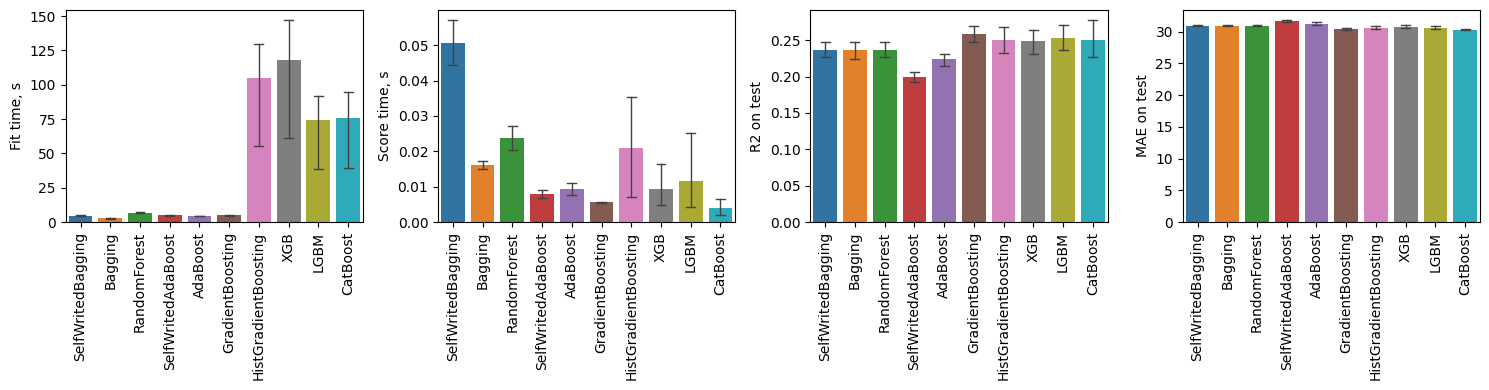

In [27]:
results = pd.read_csv(pathlib.Path("optuna_res.csv"))
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))

for y, ax in zip(["Fit time, s", "Score time, s", "R2 on test", "MAE on test"], axs.flatten()):
    sns.barplot(results[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

Как можно увидеть из графиков выше, данный датасет не подходит под задачи обучения, так как он был сгенерированным, а не основанным на каких-то реальных данных